# Stochastic Variational Inference in the TrueSkill Model:
An approach using Bayesian inference in large models with continuous latent variables and stochastic variational inference with Markov Chain Monte Carlo

## Context

I will implement a variant of the TrueSkill model, a player ranking system for competitive games originally developed for Halo 2.
It is a generalization of the Elo rating system in Chess. the original 2007 NIPS paper introducing the trueskill paper can be found here:
{http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf}. This assignment is also based on one developed by Carl Rasmussen at Cambridge for his course on probabilistic machine learning:
{http://mlg.eng.cam.ac.uk/teaching/4f13/1920/}

## Model definition

First, we'll consider a slightly simplified version of the original trueskill model.
We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior.
The prior over each player's skill is a standard normal distribution, and all player's skills are \emph{a prior} independent.  

### The likelihood.
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(\text{A beat B} | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
There can be more than one game played between a pair of players, and in this case the outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.

### The data.
The data will be an array of game outcomes.
Each row contains a pair of player indices.
The first index in each pair is the winner of the game, the second index is the loser.
If there were $M$ games played, then the array has shape $M \times 2$.

## Model Implementation

### Setup and starter code

In [9]:
using Revise
using Statistics: mean
using StatsFuns: log1pexp
using Zygote
using Test
using Logging
using Plots

┌ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1273
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
│   exception = Required dependency FFTW_jll [f5851436-0d7a-5f13-b9de-f02708fd171a] failed to load from a cache file.
└ @ Base loading.jl:1036
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for ForwardDiff [f6369f11-7733-5829-9624-2563aa707210]
│   exception = Required dependency CommonSubexpressions [bbf7d656-a473-5ed7-a52c-81e309532950] failed to load from a cache file.
└ @ Base loading.jl:1036
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
│   exception = ErrorException("Invalid input in module list: expected ZygoteRules.")
└ @ Base loading.jl:1036


In [17]:
#starter functions
function factorized_gaussian_log_density(mu,logsig,xs)
  """
  mu and logsig either same size as x in batch or same as whole batch
  returns a 1 x batchsize array of likelihoods
  """
  σ = exp.(logsig)
  return sum((-1/2)*log.(2π*σ.^2) .+ -1/2 * ((xs .- mu).^2)./(σ.^2),dims=1)
end

function skillcontour!(f; colour=nothing)
  n = 100
  x = range(-3,stop=3,length=n)
  y = range(-3,stop=3,length=n)
  z_grid = Iterators.product(x,y) # meshgrid for contour
  z_grid = reshape.(collect.(z_grid),:,1) # add single batch dim
  z = f.(z_grid)
  z = getindex.(z,1)'
  max_z = maximum(z)
  levels = [.99, 0.9, 0.8, 0.7,0.6,0.5, 0.4, 0.3, 0.2] .* max_z
  if colour==nothing
  p1 = contour!(x, y, z, fill=false, levels=levels)
  else
  p1 = contour!(x, y, z, fill=false, c=colour,levels=levels,colorbar=false)
  end
  plot!(p1)
end

function plot_line_equal_skill!()
  plot!(range(-3, 3, length=200), range(-3, 3, length=200), label="Equal Skill")
end

plot_line_equal_skill! (generic function with 1 method)

Implement a function $\text{log_prior}$ that computes the log of the prior over all player's skills.
  Specifically, given a $K \times N$ array where each row is a setting of the skills for all $N$ players, it returns a $K \times 1$ array, where each row contains a scalar giving the log-prior for that set of skills.

In [11]:
function log_prior(zs)
  mu = 0
  logsig = log(1)
  return factorized_gaussian_log_density(mu, logsig, zs)
end

log_prior (generic function with 1 method)

 Implement a function **logp_a_beats_b** that, given a pair of skills $z_a$ and $z_b$
    evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.
    To ensure numerical stability, use the function  **log1pexp** that computes $\log(1 + \exp(x))$ in a numerically stable way.
    This function is provided by **StatsFuns.jl** and imported already, and also by Python's numpy.

In [12]:
function logp_a_beats_b(za,zb)
  x = -za + zb
  return -log1pexp.(x)
end

logp_a_beats_b (generic function with 1 method)

Assuming all game outcomes are i.i.d. conditioned on all players' skills, implement a function $\texttt{all_games_log_likelihood}$ that takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives a batch of log-likelihoods for those observations.

  Specifically, given a $K \times N$ array where each row is a setting of the skills for all $N$ players, and an $M \times 2$ array of game outcomes, it returns a $K \times 1$ array, where each row contains a scalar giving the log-likelihood of all games for that set of skills.

In [14]:
function all_games_log_likelihood(zs,games)
  # games = transpose(games)
  zs_a = zs[(games)[:,1],:]
  zs_b = zs[(games)[:,2],:]
  likelihoods =  logp_a_beats_b.(zs_a, zs_b)
  return sum(likelihoods, dims = 1)
end

all_games_log_likelihood (generic function with 1 method)

Implement a function $\text(joint\_log\_density)$ which combines the log-prior and log-likelihood of the observations to give $p(z_1, z_2, \dots, z_N, \text{all game outcomes})$

In [16]:
function joint_log_density(zs,games)
  # games = transpose(games)
  return log_prior(zs) + all_games_log_likelihood(zs,games)
end

joint_log_density (generic function with 1 method)

The following below contains test cases for the above function implemented:

In [18]:
@testset "Test shapes of batches for likelihoods" begin
  B = 15 # number of elements in batch
  N = 4 # Total Number of Players
  test_zs = randn(4,15)
  test_games = [1 2; 3 1; 4 2] # 1 beat 2, 3 beat 1, 4 beat 2
  @test size(test_zs) == (N,B)
  #batch of priors
  @test size(log_prior(test_zs)) == (1,B)
  # loglikelihood of p1 beat p2 for first sample in batch
  @test size(logp_a_beats_b(test_zs[1,1],test_zs[2,1])) == ()
  # loglikelihood of p1 beat p2 broadcasted over whole batch
  @test size(logp_a_beats_b.(test_zs[1,:],test_zs[2,:])) == (B,)
  # batch loglikelihood for evidence
  @test size(all_games_log_likelihood(test_zs,test_games)) == (1,B)
  # batch loglikelihood under joint of evidence and prior
  @test size(joint_log_density(test_zs,test_games)) == (1,B)
end

Test Summary:                          | Pass  Total
Test shapes of batches for likelihoods |    6      6


Test.DefaultTestSet("Test shapes of batches for likelihoods", Any[], 6, false)

## Examining the posterior for only two players and toy data

To get a feel for this model, we'll first consider the case where we only have 2 players, $A$ and $B$.
We'll examine how the prior and likelihood interact when conditioning on different sets of games. 
The function **skillcontour!** evaluates a provided function on a grid of $z_A$ and $z_B$'s and plots the isocontours of that function. As well there is a function **plot_line_equal_skill!**. The function **two_player_toy_games** produces toy data for two players, 
I.e. **two_player_toy_games(5,3)** produces a dataset where player A wins 5 games and player B wins 3 games.

For two players $A$ and $B$, plot the isocontours of the joint prior over their skills.  Also plot the line of equal skill, $z_A = z_B$.

In [19]:
# Convenience function for producing toy games between two players.
two_player_toy_games(p1_wins, p2_wins) = vcat([repeat([1,2]',p1_wins), repeat([2,1]',p2_wins)]...)

two_player_toy_games (generic function with 1 method)

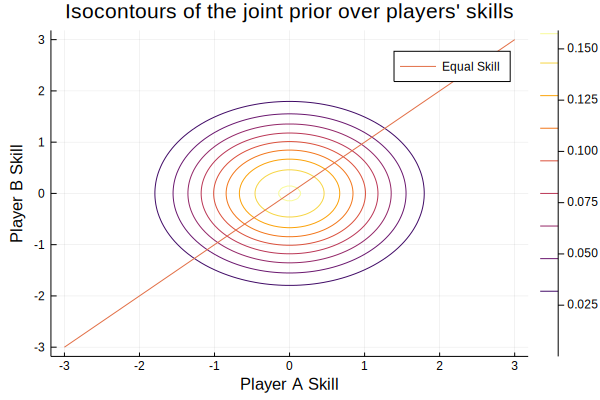

In [21]:
plot(title="Isocontours of the joint prior over players' skills",
    xlabel = "Player A Skill",
    ylabel = "Player B Skill"
   )
# TODO: plot prior contours
games = two_player_toy_games(5, 3)
joint(zs) = exp(log_prior(zs))
skillcontour!(joint)
plot_line_equal_skill!()

Plot the isocontours of the likelihood function. 
Also plot the line of equal skill, $z_A = z_B$.

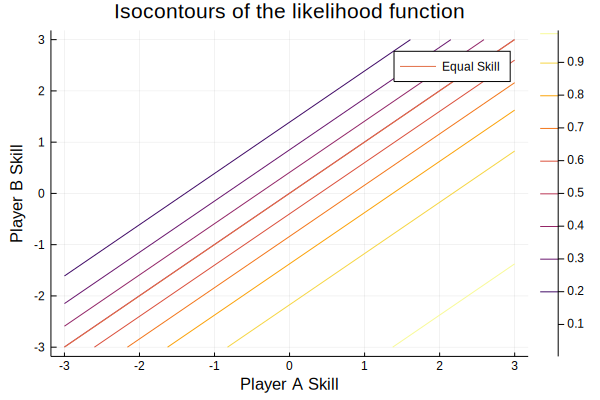

In [22]:
games = two_player_toy_games(1, 0)
plot(title="Isocontours of the likelihood function",
    xlabel = "Player A Skill",
    ylabel = "Player B Skill"
   )
likeli_(zs) = exp(all_games_log_likelihood(zs, games))
skillcontour!(likeli_)
plot_line_equal_skill!()


Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that player A
beat player B in one match.  Since the contours don't depend on the normalization
constant, we simply plot the isocontours of the log of joint distribution of
$p(z_A, z_B, \text{A beat B})$
Also plot the line of equal skill, $z_A = z_B$.

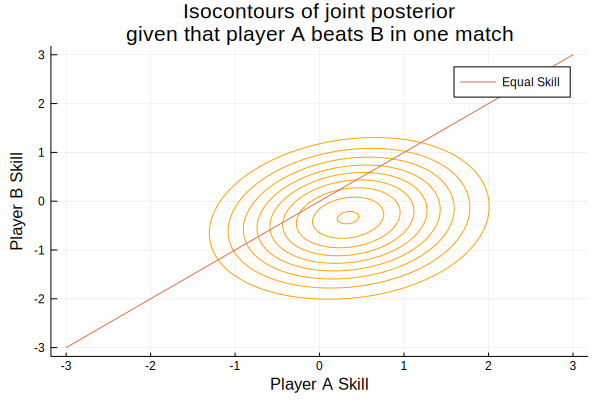

In [23]:
games = two_player_toy_games(1, 0)
plot(title="Isocontours of joint posterior
given that player A beats B in one match",
    xlabel = "Player A Skill",
    ylabel = "Player B Skill"
   )
joint1(zs) = exp(joint_log_density(zs, games))
skillcontour!(joint1, colour="orange")
plot_line_equal_skill!()

 Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that
10 matches were played, and player A beat player B all 10 times.
Also plot the line of equal skill, $z_A = z_B$.

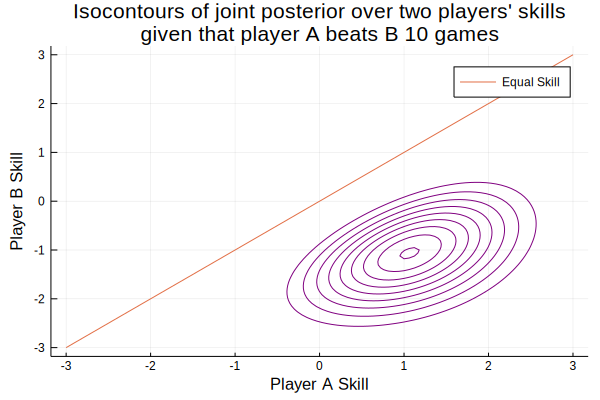

In [24]:
games = two_player_toy_games(10, 0)
plot(title="Isocontours of joint posterior over two players' skills
given that player A beats B 10 games",
    xlabel = "Player A Skill",
    ylabel = "Player B Skill"
   )
joint2(zs) = exp(joint_log_density(zs, games))
skillcontour!(joint2, colour="purple")
plot_line_equal_skill!()

Plot isocountours of the joint posterior over $z_A$ and $z_B$ given that
20 matches were played, and each player beat the other 10 times.
Also plot the line of equal skill, $z_A = z_B$.

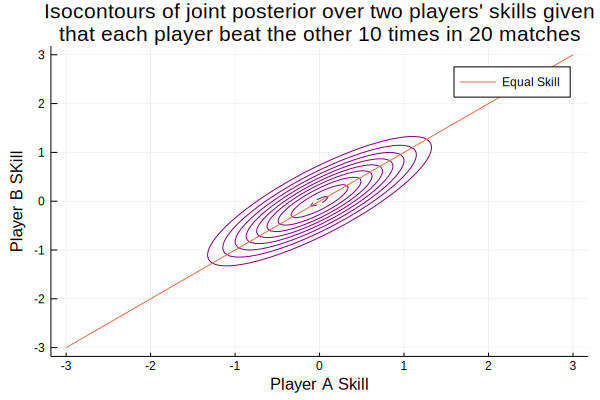

In [27]:
games = two_player_toy_games(10, 10)
#TODO: plot joint contours with player A winning 10 games and player B winning 10 games
plot(title="Isocontours of joint posterior over two players' skills given
that each player beat the other 10 times in 20 matches",
    xlabel = "Player A Skill",
    ylabel = "Player B SKill"
   )
joint3(zs) = exp(joint_log_density(zs, games))
skillcontour!(joint3, colour="purple")
plot_line_equal_skill!()


## Stochastic Variational Inference on Two Players and Toy Data 

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing. Carl Rasmussen's assignment uses Gibbs sampling, a form of **Markov Chain Monte Carlo**.

We'll use gradient-based stochastic variational inference, which wasn't invented until around 2014. 
We will also optimize an approximate posterior distribution with
stochastic variational inference to approximate the true posterior.


Implement a function **elbo** which computes an unbiased estimate of 
    the evidence lower bound.
    The ELBO is equal to the KL divergence between the true posterior $p(z|\text{data})$, and an approximate posterior, $q_\phi(z|\text{data})$, plus an unknown constant.
    Use a fully-factorized Gaussian distribution for $q_\phi(z|\text{data})$.
    This estimator takes the following arguments:
* **params**, the parameters $\phi$ of the approximate posterior $q_\phi(z|\text{data})$.
* A function **logp**, which is equal to the true posterior plus a constant.  This function must take a batch of samples of $z$.  If we have $N$ players, we can consider $B$-many samples from the joint over all players' skills. This batch of samples \texttt{zs} will be an array with dimensions $(N,B)$.
* **num_samples**, the number of samples to take.

This function will return a single scalar, and we will need to use the reparamterization trick when sampling **zs**.

In [29]:
function elbo(params,logp,num_samples)
  num_players = length(params[1])
  mu_vector = params[1] #1xN vector of everyone's mu
  log_sig_vector = params[2]
  sample = exp.(log_sig_vector) .*randn(size(params[1])[1], num_samples) .+ mu_vector
  logp_estimate = logp(sample) #1xbatchsize
  logq_estimate = factorized_gaussian_log_density((mu_vector), (log_sig_vector), sample) #1x batchsize
  return mean(logp_estimate - logq_estimate) # should return scalar (hint: average over batch)
end

elbo (generic function with 1 method)

Write a loss function called **neg\_toy\_elbo** that takes variational distribution parameters and an array of game outcomes, and returns the negative
    elbo estimate with 100 samples.

In [31]:
# Conveinence function for taking gradients
#params is 2xN matrix, N is number of players
function neg_toy_elbo(params; games = two_player_toy_games(1,0), num_samples = 100)
  # TODO: Write a function that takes parameters for q,
  # evidence as an array of game outcomes,
  # and returns the -elbo estimate with num_samples many samples from q
  logp(zs) = joint_log_density(zs,games)
  return -elbo(params,logp, num_samples)
end

neg_toy_elbo (generic function with 1 method)

Write an optimization function **fit\_toy\_variational\_dist**
which takes initial variational parameters, and the evidence.
Inside it will perform a number of iterations of gradient descent where for each iteration :
* Compute the gradient of the loss with respect to the parameters using automatic differentiation.
* Update the parameters by taking an \texttt{lr}-scaled step in the direction of the descending gradient.
* Report the loss with the new parameters (using \texttt{@info} or print statements)
* On the same set of axes plot the target distribution in red and the variational approximation in blue.

Return the parameters resulting from training.

In [80]:
# Toy game
num_players_toy = 2
toy_mu = [0, 0] # Initial mu, can initialize randomly!
toy_ls = [0.5,0.] # Initual log_sigma, can initialize randomly!
toy_params_init = (toy_mu, toy_ls)

function fit_toy_variational_dist(init_params, toy_evidence; num_itrs=200, lr= 1e-2, num_q_samples = 10)
  params_cur = init_params
  for i in 1:num_itrs
    neg_elbo_estimate = neg_toy_elbo(params_cur; games = toy_evidence, num_samples =num_q_samples)
    grad_params = gradient(param_theta -> neg_toy_elbo(param_theta; games= toy_evidence, num_samples= num_q_samples), params_cur)#TODO: gradients of variational objective with respect to parameters
    params_cur = params_cur .- lr .* grad_params[1]  # update paramters with lr-sized step in descending gradient
    
    mod_ = num_itrs/10 #only display elbo of every mod_ iterations
    if (i==1) |  (i%mod_ == 0) 
        @info "iteration number: $i"
        @info  "negative elbo: $(neg_elbo_estimate)" #report the current elbbo during training
    end
    # plot true posterior in red and variational in blue
    # call 'display' on final plot to make it display during training
    plot();
    target_posterior(zs) = exp(joint_log_density(zs, toy_evidence))
    skillcontour!(target_posterior,colour=:red) #plot likelihood contours for target posterior
    plot_line_equal_skill!()

    likelihood_countours(zs) =
    exp(factorized_gaussian_log_density(params_cur[1],params_cur[2],zs))
    if (i==1) |  (i%mod_ == 0) #only plot for every 10 iterations
        display(skillcontour!(likelihood_countours, colour=:blue)) #plot likelihood contours for variational posterior
    end
  end
  return params_cur
end

fit_toy_variational_dist (generic function with 1 method)

Initialize a variational distribution parameters and optimize them to approximate the joint
where we observe player A winning **1 game**.  
Report the final loss.  
Also plot the optimized variational approximation contours (in blue) and the target distribution (in red) on the same axes. 

*Note that we will only display the negative elbo and the plot for every **num_iter/10** iteration (for conciseness in report)* 

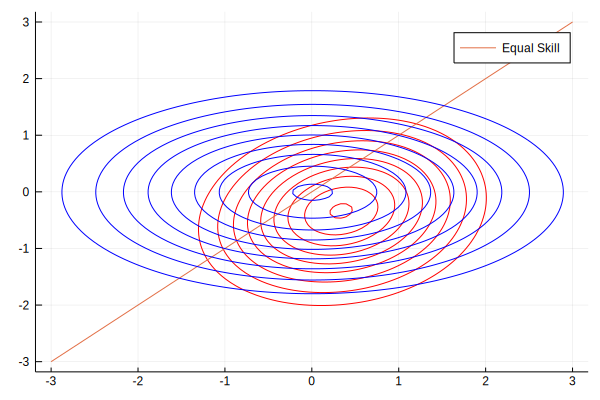

┌ Info: iteration number: 1
└ @ Main In[80]:16


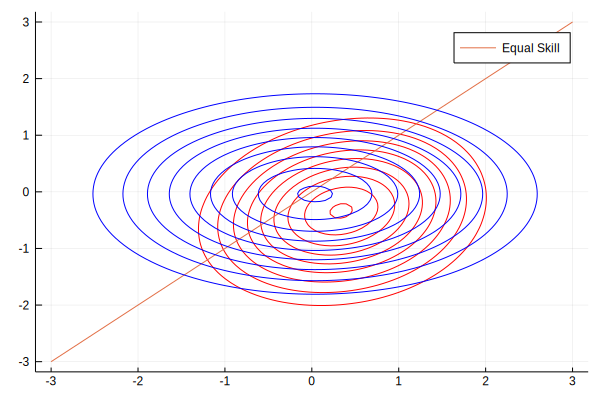

┌ Info: negative elbo: 1.5965660402573278
└ @ Main In[80]:17
┌ Info: iteration number: 10
└ @ Main In[80]:16


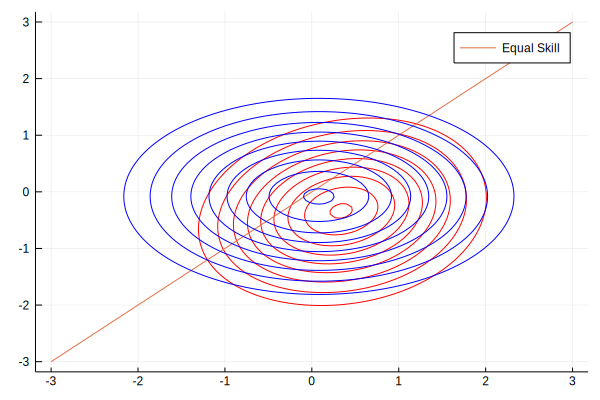

┌ Info: negative elbo: 1.1762443922343417
└ @ Main In[80]:17
┌ Info: iteration number: 20
└ @ Main In[80]:16
┌ Info: negative elbo: 1.0646033069261238
└ @ Main In[80]:17


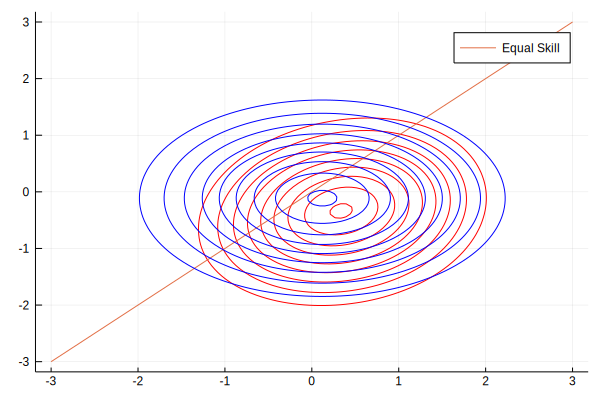

┌ Info: iteration number: 30
└ @ Main In[80]:16


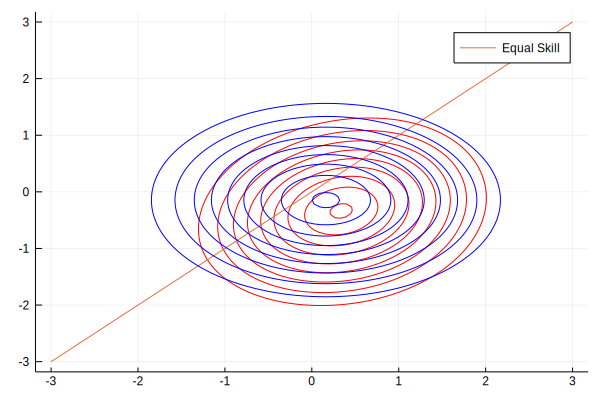

┌ Info: negative elbo: 0.8149803391468847
└ @ Main In[80]:17
┌ Info: iteration number: 40
└ @ Main In[80]:16


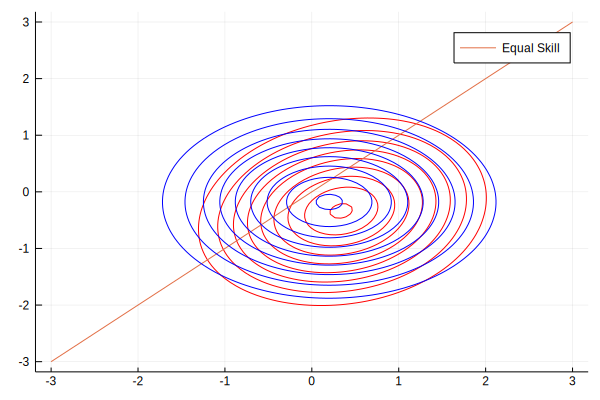

┌ Info: negative elbo: 0.8208836289949041
└ @ Main In[80]:17
┌ Info: iteration number: 50
└ @ Main In[80]:16


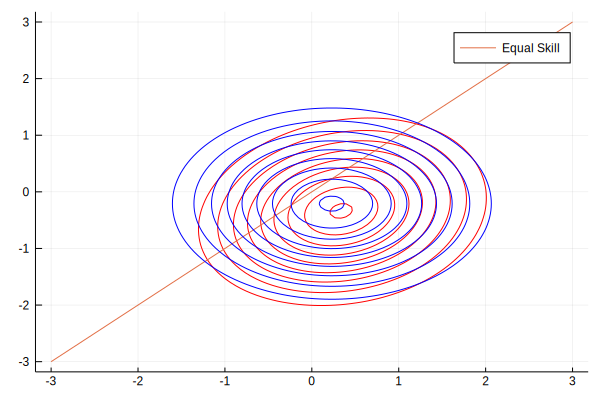

┌ Info: negative elbo: 0.7366670318698728
└ @ Main In[80]:17
┌ Info: iteration number: 60
└ @ Main In[80]:16


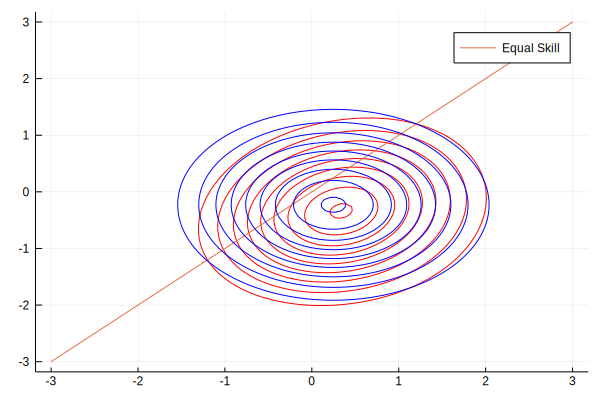

┌ Info: negative elbo: 0.7653875529425891
└ @ Main In[80]:17
┌ Info: iteration number: 70
└ @ Main In[80]:16


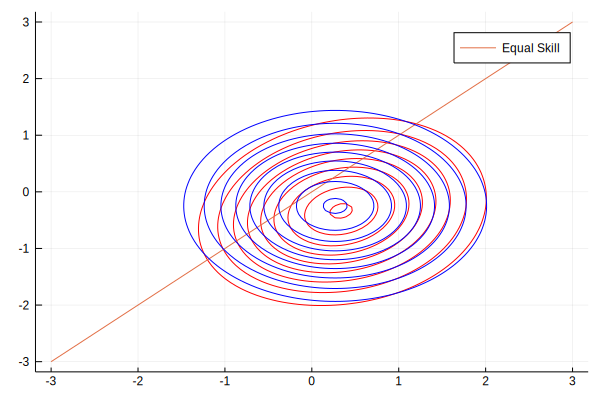

┌ Info: negative elbo: 0.7838997187668372
└ @ Main In[80]:17
┌ Info: iteration number: 80
└ @ Main In[80]:16


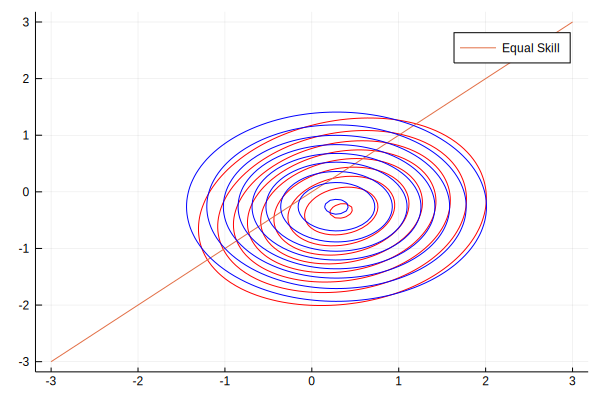

┌ Info: negative elbo: 0.7884892324634339
└ @ Main In[80]:17
┌ Info: iteration number: 90
└ @ Main In[80]:16


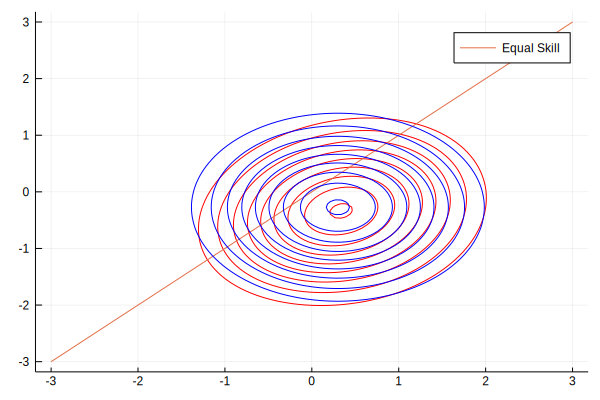

┌ Info: negative elbo: 0.7182543694254139
└ @ Main In[80]:17
┌ Info: iteration number: 100
└ @ Main In[80]:16
┌ Info: negative elbo: 0.702521457094273
└ @ Main In[80]:17


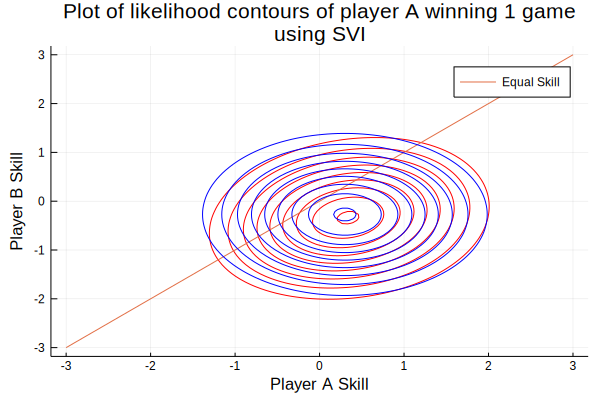

In [82]:
#fit q with SVI observing player A winning 1 game
games = two_player_toy_games(1, 0)
fit_toy_variational_dist(toy_params_init, games; num_itrs=100, lr= 1e-2, num_q_samples = 50)
plot!(title="Plot of likelihood contours of player A winning 1 game 
    using SVI", xlabel="Player A Skill",ylabel="Player B Skill" )

Initialize a variational distribution parameters and optimize them to approximate the joint
    where we observe player A winning **10 games**.

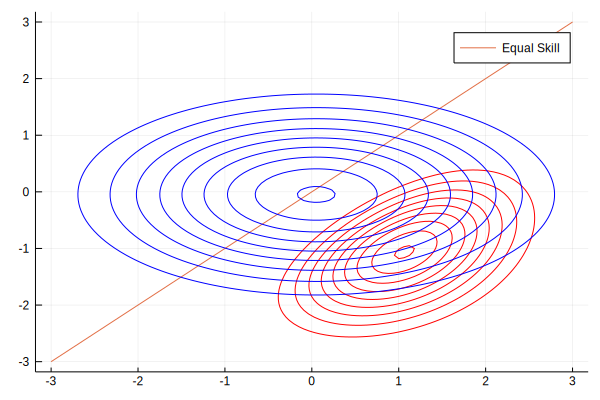

┌ Info: iteration number: 1
└ @ Main In[80]:16
┌ Info: negative elbo: 11.763392339208774
└ @ Main In[80]:17


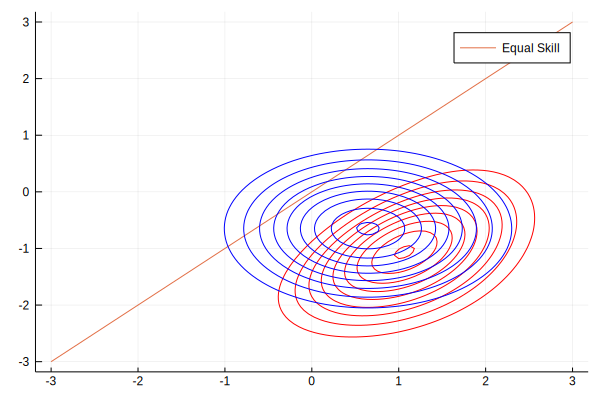

┌ Info: iteration number: 20
└ @ Main In[80]:16


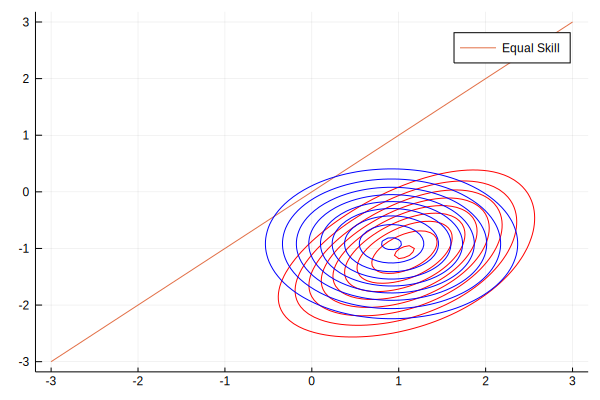

┌ Info: negative elbo: 4.770114263886256
└ @ Main In[80]:17
┌ Info: iteration number: 40
└ @ Main In[80]:16


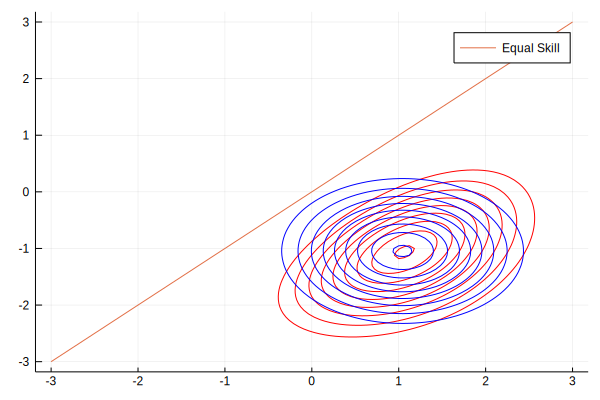

┌ Info: negative elbo: 3.2727391041796023
└ @ Main In[80]:17
┌ Info: iteration number: 60
└ @ Main In[80]:16


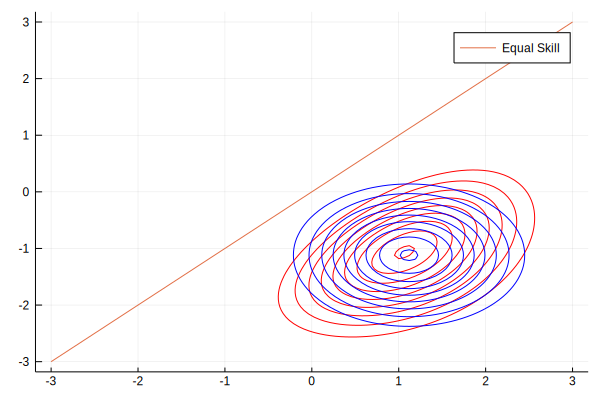

┌ Info: negative elbo: 2.9585787363076586
└ @ Main In[80]:17
┌ Info: iteration number: 80
└ @ Main In[80]:16


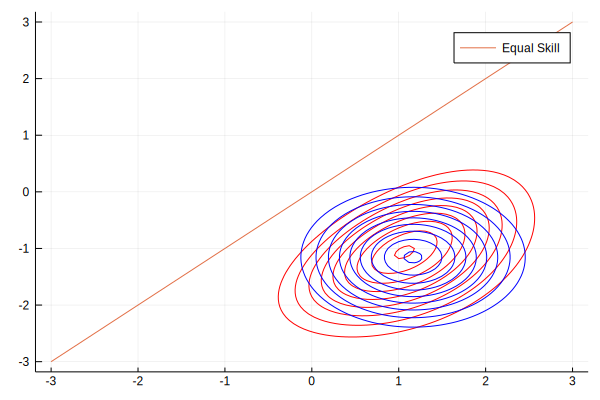

┌ Info: negative elbo: 2.9640859307663114
└ @ Main In[80]:17
┌ Info: iteration number: 100
└ @ Main In[80]:16


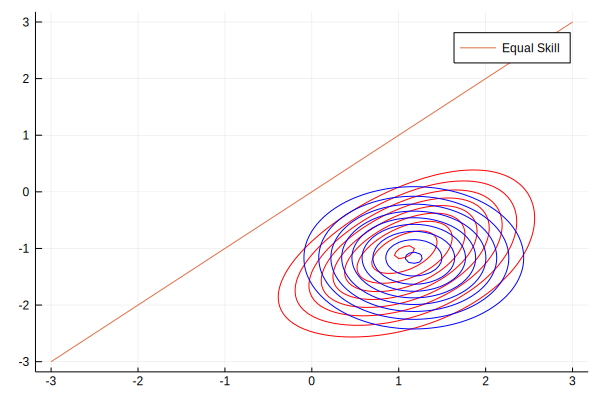

┌ Info: negative elbo: 2.949858034624394
└ @ Main In[80]:17
┌ Info: iteration number: 120
└ @ Main In[80]:16


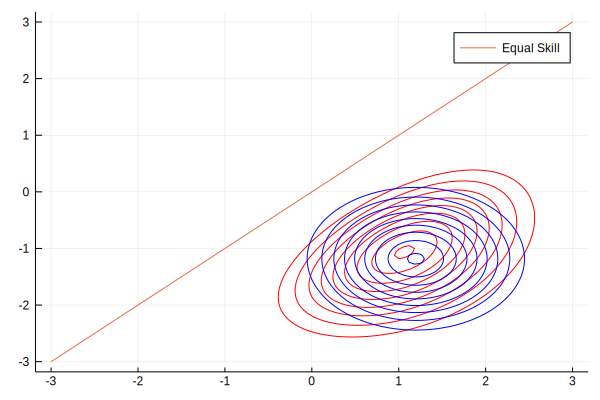

┌ Info: negative elbo: 2.701126537205562
└ @ Main In[80]:17
┌ Info: iteration number: 140
└ @ Main In[80]:16


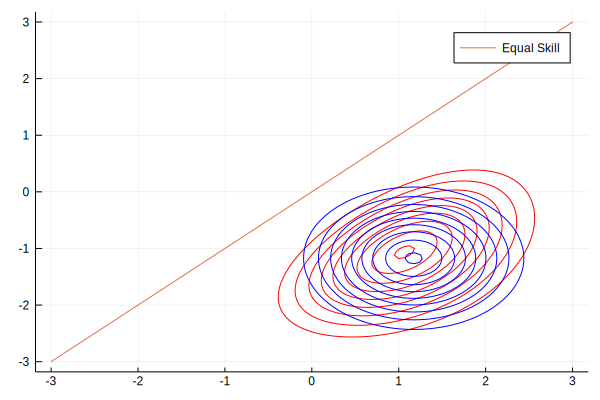

┌ Info: negative elbo: 3.081015709381557
└ @ Main In[80]:17
┌ Info: iteration number: 160
└ @ Main In[80]:16


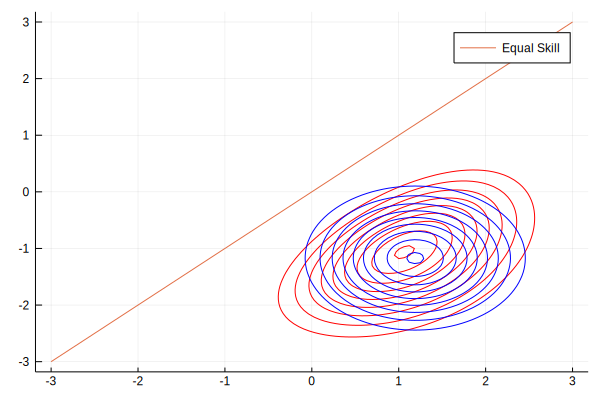

┌ Info: negative elbo: 2.8610281612411077
└ @ Main In[80]:17
┌ Info: iteration number: 180
└ @ Main In[80]:16


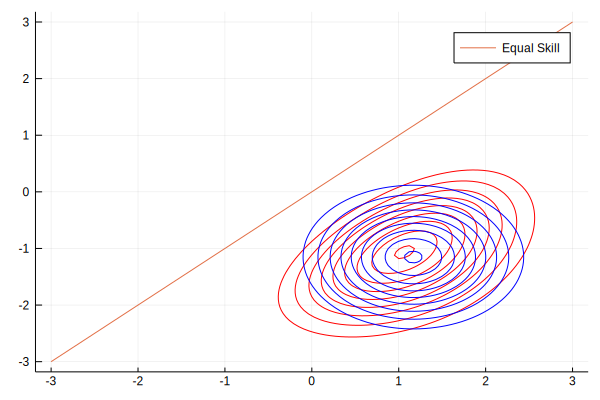

┌ Info: negative elbo: 2.857554606570369
└ @ Main In[80]:17
┌ Info: iteration number: 200
└ @ Main In[80]:16
┌ Info: negative elbo: 2.968039670010575
└ @ Main In[80]:17


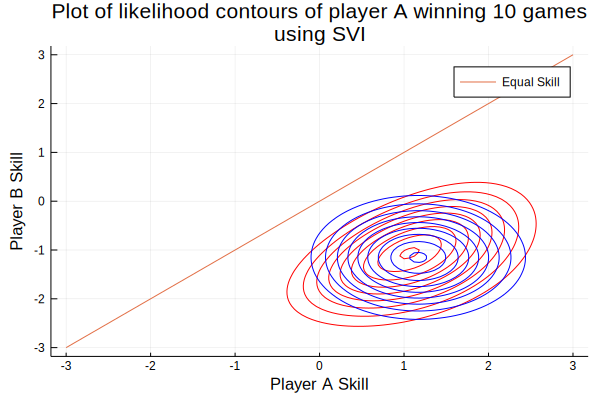

In [84]:
#fit q with SVI observing player A winning 10 games
games = two_player_toy_games(10, 0)
fit_toy_variational_dist(toy_params_init, games; num_itrs=200, lr= 1e-2, num_q_samples = 20)
plot!(title="Plot of likelihood contours of player A winning 10 games
    using SVI", xlabel="Player A Skill",ylabel="Player B Skill" )

Initialize a variational distribution parameters and optimize them to approximate the jointwhere we observe **player A winning 10 games and player B winning 10 games**.

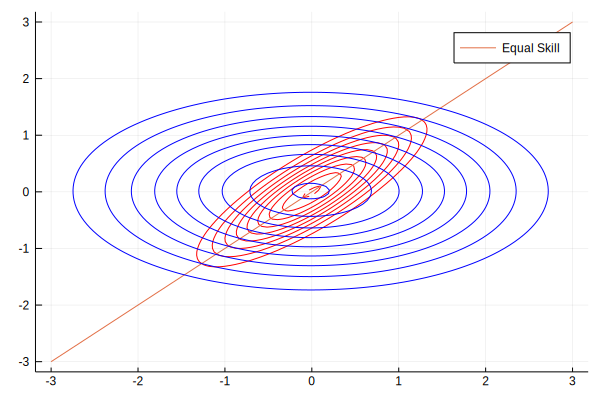

┌ Info: iteration number: 1
└ @ Main In[80]:16


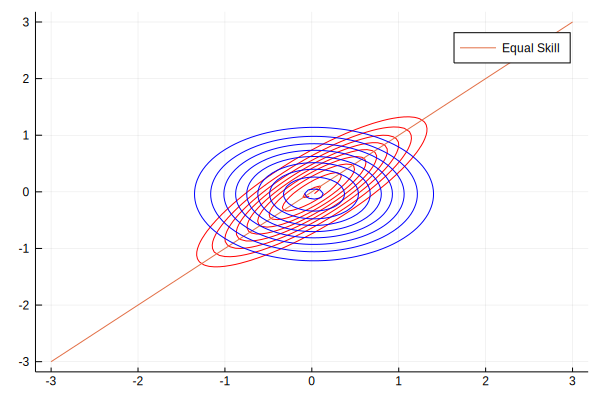

┌ Info: negative elbo: 23.426382733378606
└ @ Main In[80]:17
┌ Info: iteration number: 20
└ @ Main In[80]:16


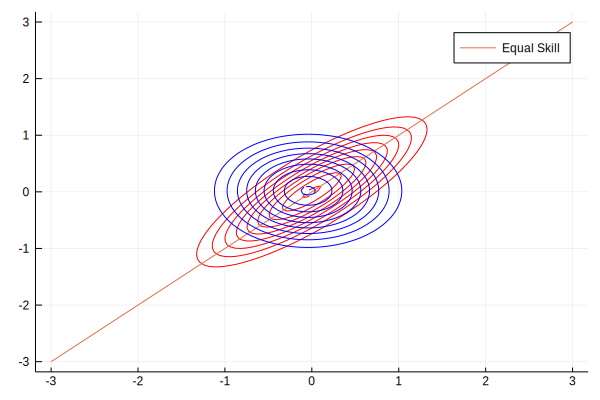

┌ Info: negative elbo: 16.516896987470695
└ @ Main In[80]:17
┌ Info: iteration number: 40
└ @ Main In[80]:16
┌ Info: negative elbo: 15.857474174428896
└ @ Main In[80]:17


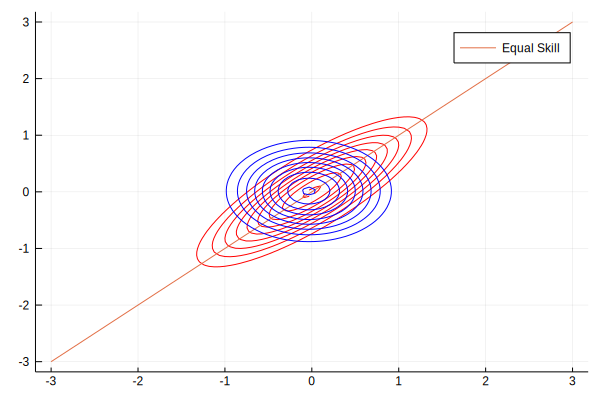

┌ Info: iteration number: 60
└ @ Main In[80]:16


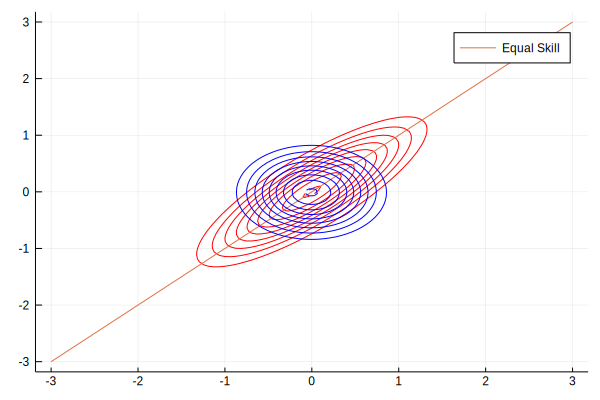

┌ Info: negative elbo: 16.319848240550364
└ @ Main In[80]:17
┌ Info: iteration number: 80
└ @ Main In[80]:16


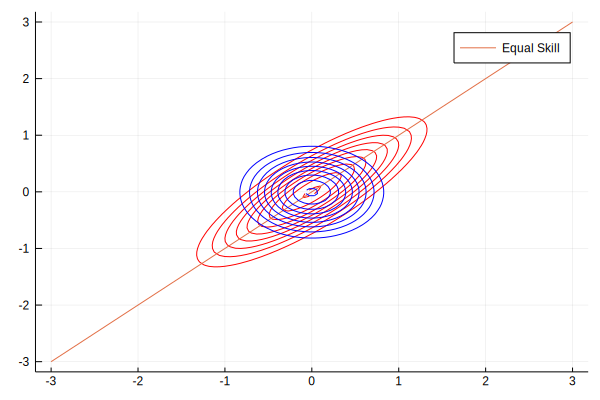

┌ Info: negative elbo: 15.826706611044113
└ @ Main In[80]:17
┌ Info: iteration number: 100
└ @ Main In[80]:16
┌ Info: negative elbo: 15.198001934631794
└ @ Main In[80]:17


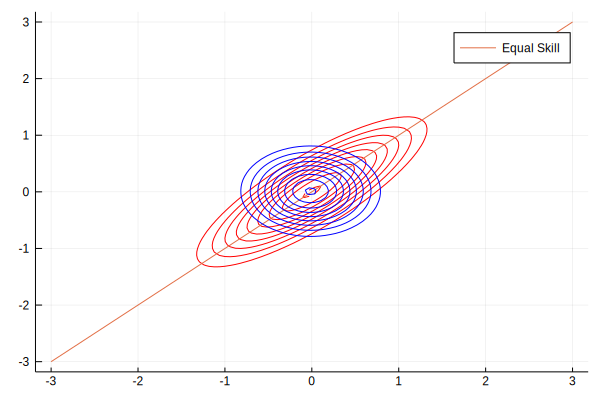

┌ Info: iteration number: 120
└ @ Main In[80]:16


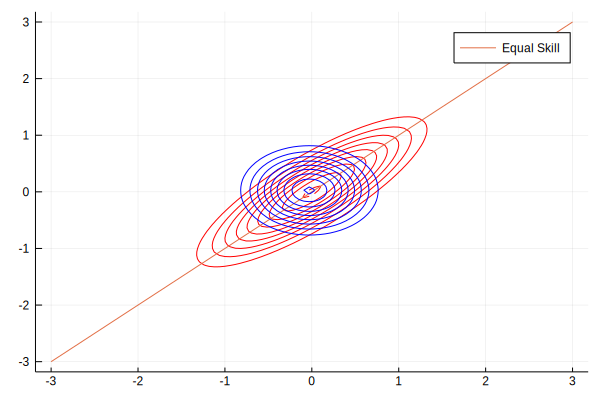

┌ Info: negative elbo: 15.582278497906705
└ @ Main In[80]:17
┌ Info: iteration number: 140
└ @ Main In[80]:16


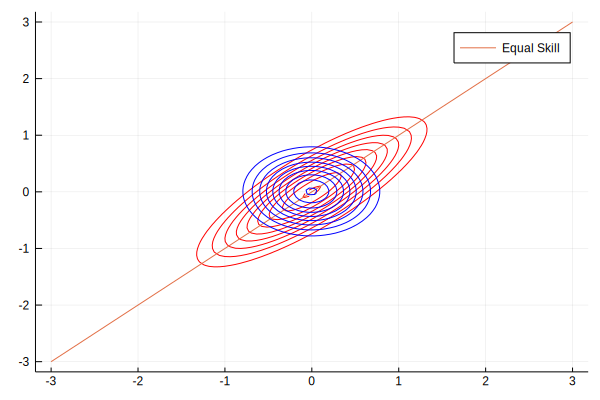

┌ Info: negative elbo: 15.75313366041155
└ @ Main In[80]:17
┌ Info: iteration number: 160
└ @ Main In[80]:16


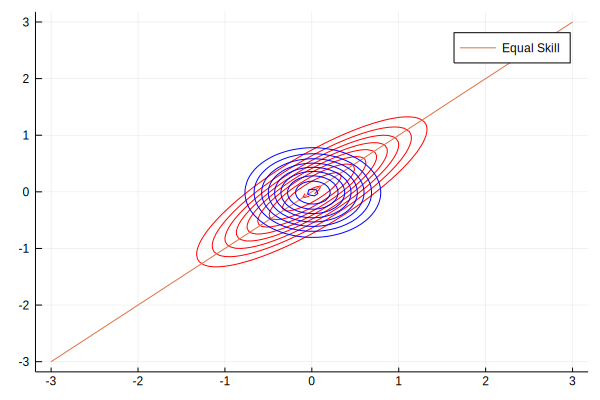

┌ Info: negative elbo: 15.925939407641218
└ @ Main In[80]:17
┌ Info: iteration number: 180
└ @ Main In[80]:16


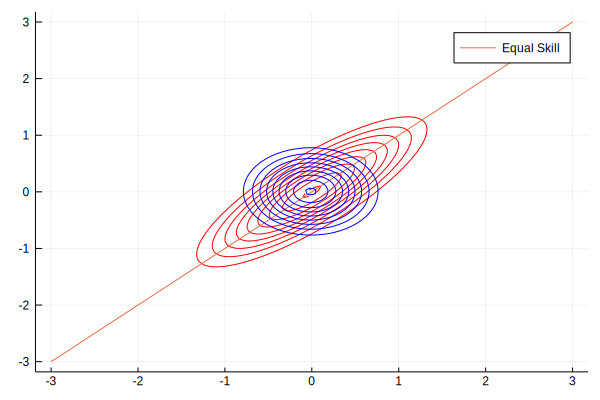

┌ Info: negative elbo: 15.322612259671939
└ @ Main In[80]:17
┌ Info: iteration number: 200
└ @ Main In[80]:16
┌ Info: negative elbo: 15.288157333581996
└ @ Main In[80]:17


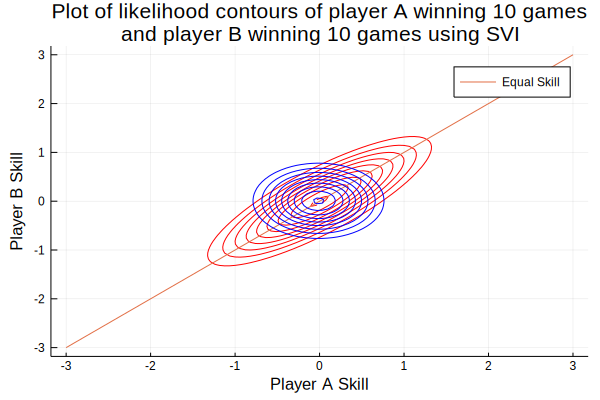

In [86]:
#fit q with SVI observing player A winning 10 games and player B winning 10 games
games = two_player_toy_games(10, 10)
fit_toy_variational_dist(toy_params_init, games; num_itrs=200, lr= 1e-2, num_q_samples = 20)
plot!(title="Plot of likelihood contours of player A winning 10 games
    and player B winning 10 games using SVI", xlabel="Player A Skill",ylabel="Player B Skill" )

## Approximate inference conditioned on real data

Load the dataset from **tennis_data.mat** containing two matrices:
* W is a 107 by 1 matrix, whose $i$’th entry is the name of player $i$.
* G is a 1801 by 2 matrix of game outcomes (actually tennis matches), one row per game.
The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

In [87]:
using MAT
vars = matread("tennis_data.mat")
player_names = vars["W"]
tennis_games = Int.(vars["G"])
num_players = length(player_names)
print("Loaded data for $num_players players")

┌ Info: Precompiling MAT [23992714-dd62-5051-b70f-ba57cb901cac]
└ @ Base loading.jl:1273


Loaded data for 107 players

### An observation

Note that for any two players $i$ and $j$, $p(z_i, z_j | \text{all games})$ is always proportional to
$p(z_i, z_j , \text{all games})$. 
Hence, in general, the isocontours of $p(z_i, z_j | \text{all games})$ are the same as those of
$p(z_i, z_j | \text{games between i and j})$. That is, the games between
other players besides $i$ and $j$ provide information about the skill of players $i$ and $j$.  

An intuitive way to think about this is to imagine a player $k$, who played with both player $i$ and $j$. Then whoever wins player $k$, provides information of the skills of player $i$ and $j$, even if player $i$ and $j$ never plays with each other directly.

### New Optimization

Write a new optimization function **fit\_variational\_dist** like the one from the 
  previous question except it does not plot anything.
  Initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.
  Report the final negative ELBO estimate after optimization.

In [93]:
function fit_variational_dist(init_params, tennis_games; num_itrs=100, lr= 1e-2, num_q_samples = 10)
  params_cur = init_params
  for i in 1:num_itrs
    neg_elbo_estimate = neg_toy_elbo(params_cur; games = tennis_games, num_samples =num_q_samples)
    grad_params = gradient(param_theta -> neg_toy_elbo(param_theta; games= tennis_games, num_samples= num_q_samples), params_cur)#TODO: gradients of variational objective with respect to parameters
    params_cur = params_cur .- lr .* grad_params[1]  #TODO: update paramters with lr-sized step in descending gradient
    mod_ = num_itrs/10 #only display elbo of every mod_ iterations
    if (i==1) |  (i%mod_ == 0) 
        @info  "elbo: $(neg_elbo_estimate)" #TODO: report the current elbbo during training
    end
  end
  return params_cur
end

fit_variational_dist (generic function with 1 method)

In [94]:
#Initialize variational family
init_mu = rand(107) #random initialziation
init_log_sigma = rand(107) # random initialziation
init_params = (init_mu, init_log_sigma)

# Train variational distribution
trained_params = fit_variational_dist(init_params, tennis_games)

┌ Info: elbo: 2261.795604002863
└ @ Main In[93]:9
┌ Info: elbo: 1324.5630405761315
└ @ Main In[93]:9
┌ Info: elbo: 1208.4123936562416
└ @ Main In[93]:9
┌ Info: elbo: 1183.3028985334436
└ @ Main In[93]:9
┌ Info: elbo: 1162.5519334634412
└ @ Main In[93]:9
┌ Info: elbo: 1154.8989801074417
└ @ Main In[93]:9
┌ Info: elbo: 1150.6918996809295
└ @ Main In[93]:9
┌ Info: elbo: 1148.7886414173915
└ @ Main In[93]:9
┌ Info: elbo: 1146.4082858827749
└ @ Main In[93]:9
┌ Info: elbo: 1146.2653916726224
└ @ Main In[93]:9
┌ Info: elbo: 1145.9004569803121
└ @ Main In[93]:9


([2.5763634616758067, 0.5193828680810878, 1.2965849400089269, 0.9916634584156165, 2.5475502252487554, 1.5587190034676068, -0.3517581318334303, 0.8819318805189508, 0.7388241147396905, 0.12082598302891283  …  -0.5706793960672065, -0.08698066654127157, 0.23828612599166674, 0.03372960501736948, -0.6312912530642479, -0.20814303629238862, -0.017902738613126815, -0.9469412802139814, 0.007650461571221129, -0.18925472544549754], [-1.1584121798868057, -1.051287992308367, -1.1583003759223434, -1.1878768275490874, -1.1550302863180746, -1.2316663913454071, -0.94084360332973, -1.228634187444756, -1.065835378424764, -1.133228403913937  …  -0.07922233646971095, -0.055154668065536046, -0.02935433561909053, -0.15996447793590537, -0.19919058998781125, -0.02181235213026785, 0.001927360167031403, -0.38496979838638345, -0.09147491347857287, -0.06315836433473931])

Plot the approximate mean and variance of all players, sorted by skill.

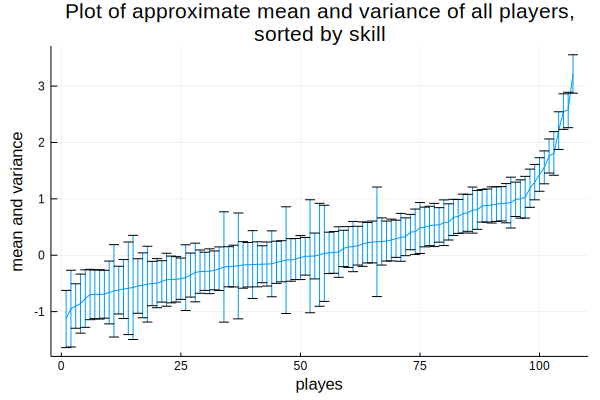

In [96]:
means = trained_params[1]
logstd = trained_params[2]
perm = sortperm(means)
plot(title = "Plot of approximate mean and variance of all players,
sorted by skill", xlabel = "playes", ylabel = "mean and variance", means[perm], yerror=exp.(logstd[perm]), label = "")

List the names of the 10 players with the highest mean skill under the variational model.

In [97]:
sorted = sortperm(means, rev= true)
player_names[sorted[1:10]]

10-element Array{Any,1}:
 "Novak-Djokovic"       
 "Rafael-Nadal"         
 "Roger-Federer"        
 "Andy-Murray"          
 "Robin-Soderling"      
 "David-Ferrer"         
 "Jo-Wilfried-Tsonga"   
 "Tomas-Berdych"        
 "Juan-Martin-Del-Potro"
 "Richard-Gasquet"      

Plot the joint posterior over the skills of Roger Federer and Rafael Nadal.

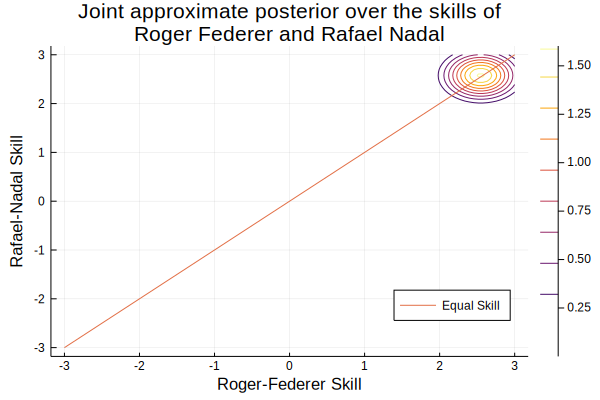

In [98]:
Roger_Federer_index = findall(x -> x=="Roger-Federer", player_names)[1][1]
Rafael_Nadal_index = findall(x -> x=="Rafael-Nadal", player_names)[1][1]

Roger_Federer_mu = means[Roger_Federer_index]
Roger_Federer_sig = logstd[Roger_Federer_index]

Rafael_Nadal_mu = means[Rafael_Nadal_index]
Rafael_Nadal_sig = logstd[Rafael_Nadal_index]

vector_two_players_mu = [Roger_Federer_mu, Rafael_Nadal_mu]
vector_two_players_sig = [Roger_Federer_sig, Rafael_Nadal_sig ]
plot(title="Joint approximate posterior over the skills of
 Roger Federer and Rafael Nadal",
    xlabel = "Roger-Federer Skill",
    ylabel = "Rafael-Nadal Skill",
    legend = :bottomright
   )
approx_posterior(zs) = exp(factorized_gaussian_log_density(vector_two_players_mu, vector_two_players_sig, zs))
skillcontour!(approx_posterior)
plot_line_equal_skill!()

Derive the exact probability under a factorized Guassian over two players' skills that one has higher skill than the other, as a function of the two means and variances over their skills. Use the fact that:
* a linear change of variables $y_A, y_B = z_A - z_B, z_B$
* If $X \sim \mathcal{N}(\mu, \Sigma)$, then $AX \sim \mathcal{N}(A \mu, A^{T} \Sigma A)$ 
* if $X \sim \mathcal{N}(\mu, \Sigma)$, then the $i$th element of $X$ has a marginal distribution $X_i \sim \mathcal{N}(\mu_i, \Sigma_{ii})$ 

In [100]:
using StatsFuns: normcdf

function derive_exact(player1, player2)
  player1_index = findall(x -> x==player1, player_names)[1][1]
  player2_index = findall(x -> x==player2, player_names)[1][1]

  player1_mu = means[player1_index]
  player2_mu = means[player2_index]

  player1_log_sig = logstd[player1_index]
  player2_log_sig = logstd[player2_index]

  z_a = (player1_mu, player1_log_sig)
  z_b = (player2_mu, player2_log_sig)

  transform_A_mu = [(z_a[1] - z_b[1])/z_a[1] 0; 0 1] #transformation matrix
  mu = vec([z_a[1] z_b[2]]) #vector of 2 player mu
  A_mu = (transform_A_mu * mu)[1] #mean of AX, indexing first element

  z_a_sig = (z_a[2])
  z_b_sig = (z_b[2])

  transform_A_sig = [(z_a[2] - z_b[2])/z_b[2] 0; 0 1]
  sig = [z_a[2] 0 ; 0 z_b[2]]
  sig = transform_A_sig * sig * transpose(transform_A_sig)
  A_sig = sig[1] #sig of AX, indexing left top corner
  #i.e., y_a ~N(mu_1 - mu_2, exp(sig_1 + sig_2))
  return A_mu, exp(A_sig)
end

derive_exact (generic function with 1 method)

In [103]:
function monte_carlo(player1, player2, sample_size)
  player1_index = findall(x -> x==player1, player_names)[1][1]
  player2_index = findall(x -> x==player2, player_names)[1][1]

  player1_mu = means[player1_index]
  player2_mu = means[player2_index]

  player1_log_sig = logstd[player1_index]
  player2_log_sig = logstd[player2_index]

  random_samples = randn(2, sample_size) #(N,K) random samples

  samples_p1 = exp(player1_log_sig) .* random_samples[1,:] .+ player1_mu
  samples_p2 = exp(player2_log_sig) .* random_samples[2,:] .+ player2_mu

  all_ones = samples_p1 .> samples_p2 #a vector of 0's and 1's, where 1 represents p1 skill > p2 skill
  count = sum(x->x==1, all_ones, dims=1) #count number of 1's
  sample_prob = count[1]/sample_size # prob using MC
  return sample_prob
end

monte_carlo (generic function with 1 method)

 Compute the probability under your approximate posterior that
	Roger Federer has higher skill than Rafael Nadal.
	Computing quantity exactly (using **derive_exact**)

In [105]:
A_mu, A_sig = derive_exact("Roger-Federer","Rafael-Nadal")
1 - normcdf(A_mu, (A_sig), 0)

0.4885066589480539

Estimating it using simple Monte Carlo with 10000 examples.

In [106]:
monte_carlo("Roger-Federer","Rafael-Nadal", 10000)

0.4673

Compute the probability that Roger Federer is better than the player
	with the lowest mean skill. Computing this quantity exactly:

In [107]:
sorted = sortperm(means, rev= false)
lowest_player = player_names[sorted[1]]
lowest_player_index = findall(x -> x == lowest_player, player_names)[1][1]
A_mu, A_sig = derive_exact("Roger-Federer",lowest_player)
1 - normcdf(A_mu, (A_sig), 0)

0.9999999999629207

Estimating it using simple Monte Carlo with 10000 examples.

In [108]:
monte_carlo("Roger-Federer", lowest_player, 1000000)

1.0